In [2]:

from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

products = DatasetReader(data_folder).get_data_csv('products.csv')
orders = DatasetReader(data_folder).get_data_csv('orders.csv')
order_items = DatasetReader(data_folder).get_data_csv('order_items.csv')
inventory_items = DatasetReader(data_folder).get_data_csv('inventory_items.csv')

# Select specific columns from each DataFrame
order_items_selected = order_items[['product_id','order_id','status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at', 'sale_price']]
orders_selected = orders[['order_id', 'gender', 'num_of_item']]  # Including 'order_id' for joining
products_selected = products[['id', 'cost', 'category', 'name', 'brand', 'retail_price', 'department', 'sku']]  # Including 'id' for joining

# Perform the join operations based on the relationships identified in the queries
# Assuming 'order_id' is common between 'order_items' and 'orders'
# Assuming 'product_id' is common between 'order_items' and 'products'

merged_df = order_items_selected \
    .merge(orders_selected, on='order_id', how='inner') \
    .merge(products_selected, left_on='product_id', right_on='id', how='inner')



merged_df.drop(columns=['product_id', 'order_id', 'id'], inplace=True)

# place sku to the beginning of the dataframe
cols = list(merged_df.columns)
cols.insert(0, cols.pop(cols.index('sku')))
merged_df = merged_df.loc[:, cols]

# checl if sale_price is equal to retail_price
merged_df.query('sale_price != retail_price')
merged_df.drop(columns=['retail_price'], inplace=True)

#trainsform dates to datetime
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['shipped_at'] = pd.to_datetime(merged_df['shipped_at'])
merged_df['delivered_at'] = pd.to_datetime(merged_df['delivered_at'])
merged_df['returned_at'] = pd.to_datetime(merged_df['returned_at'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def aggregate_sales_with_all_columns(data, sku_col='sku', price_col='sale_price', time_col='created_at', sales_col='num_of_item'):
    """Aggregate sales by SKU, price, and time while retaining other columns."""
    
    # Extract the date from the timestamp for daily aggregation
    data['date'] = data[time_col].dt.date
    
    # Aggregating sales and retaining other columns
    aggregation_methods = {sales_col: 'sum'}
    for col in data.columns:
        if col not in [sku_col, price_col, 'date', sales_col]:
            aggregation_methods[col] = 'first'
    
    aggregated_data = data.groupby([sku_col, price_col, 'date']).agg(aggregation_methods).reset_index().rename(columns={sales_col: 'daily_sales'})
    
    return aggregated_data


In [4]:
merged_df = aggregate_sales_with_all_columns(merged_df)
merged_df.head()

,sku,sale_price,date,daily_sales,status,created_at,shipped_at,delivered_at,returned_at,gender,cost,category,name,brand,department
0,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-05-14,2,Shipped,2022-05-14 21:24:59+00:00,2022-05-15 20:22:00+00:00,NaT,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
1,00003E3B9E5336685200AE85D21B4F5E,99.000000,2022-12-09,1,Complete,2022-12-09 03:58:35+00:00,2022-12-10 03:49:00+00:00,2022-12-10 13:54:00+00:00,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
2,00003E3B9E5336685200AE85D21B4F5E,99.000000,2023-05-12,1,Complete,2023-05-12 23:08:53+00:00,2023-05-15 07:59:00+00:00,2023-05-18 01:27:00+00:00,NaT,F,56.232000,Pants & Capris,Anne Klein Women's Crop Pant,Anne Klein,Women
3,0004D0B59E19461FF126E3A08A814C33,79.949997,2020-08-31,1,Processing,2020-08-31 08:42:06+00:00,NaT,NaT,NaT,F,37.656449,Fashion Hoodies & Sweatshirts,The Bradford Exchange Breast Cancer Support Wo...,Bradford Exchange,Women
4,0004D0B59E19461FF126E3A08A814C33,79.949997,2022-10-19,1,Shipped,2022-10-19 10:38:15+00:00,2022-10-21 14:40:00+00:00,NaT,NaT,F,37.656449,Fashion Hoodies & Sweatshirts,The Bradford Exchange Breast Cancer Support Wo...,Bradford Exchange,Women


In [5]:
# drop status = 'Cancelled'
merged_df = merged_df[merged_df['status'] != 'Cancelled']

<Axes: title={'center': 'Monthly Average Sale Price'}, xlabel='created_at'>

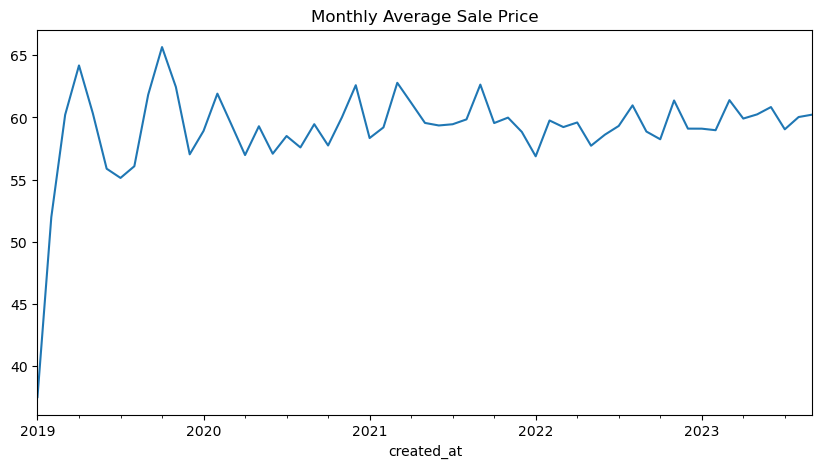

In [11]:
# plot sale_price with created_at
#merged_df.plot(x='created_at', y='sale_price', figsize=(10, 5), title='Sale Price vs. Created At')
#merged_df['sale_price'].plot(kind='hist', bins=100, figsize=(10, 5), title='Histogram of Sale Price')
# plot monthly sale_price usuing plotly

merged_df.groupby(pd.Grouper(key='created_at', freq='M'))['sale_price'].mean().plot(figsize=(10, 5), title='Monthly Average Sale Price')


In [12]:
# convert this plot to plotly merged_df.groupby(pd.Grouper(key='created_at', freq='M'))['sale_price'].mean().plot(figsize=(10, 5), title='Monthly Average Sale Price')

# plot monthly sale_price usuing plotly
import plotly.express as px
fig = px.line(merged_df.groupby(pd.Grouper(key='created_at', freq='M'))['sale_price'].mean().reset_index(), x='created_at', y='sale_price', title='Monthly Average Sale Price')
fig.show()

In [7]:
from src.data.feature_engineering import FeatureEngineeringProcess
fep = FeatureEngineeringProcess()

In [14]:
df, insuficient_data = fep.filter_stability_periods(merged_df, 7, 0.04, sku_column='sku', date_column='created_at', price_column='sale_price')

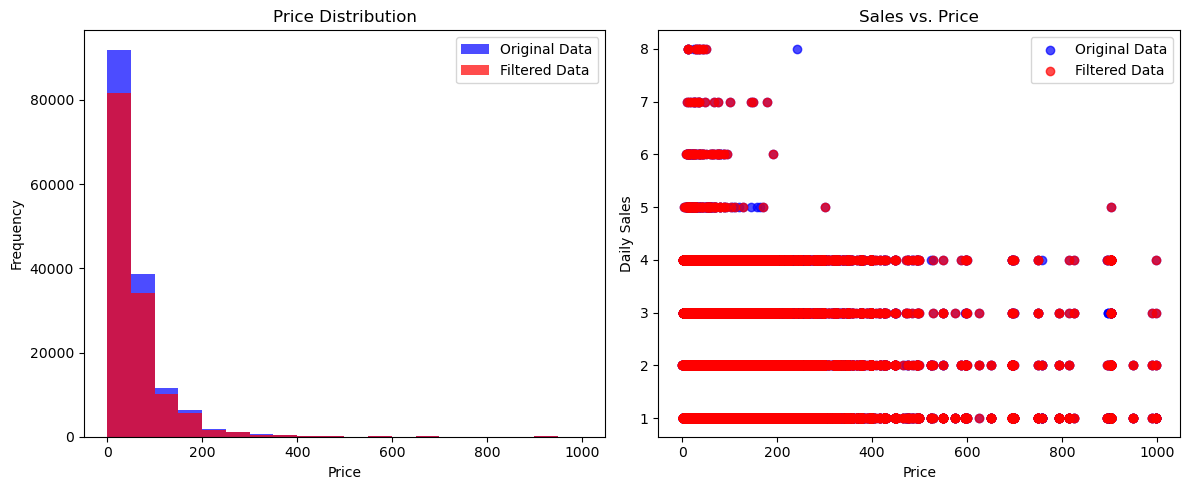

{'Original Price Standard Deviation': 66.51512482870987,
 'Filtered Price Standard Deviation': 66.32740996616222,
 'Percentage of Data Removed': 11.458258407496292}

In [15]:
# plot  the daily price change

import matplotlib.pyplot as plt

# Simple Statistics
original_std = merged_df['sale_price'].std()
filtered_std = df['sale_price'].std()
data_reduction = (1 - len(df) / len(merged_df)) * 100

statistics = {
    "Original Price Standard Deviation": original_std,
    "Filtered Price Standard Deviation": filtered_std,
    "Percentage of Data Removed": data_reduction
}

# Visualizations
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Price Distribution
ax[0].hist(merged_df['sale_price'], color='blue', alpha=0.7, label='Original Data', bins=20)
ax[0].hist(df['sale_price'], color='red', alpha=0.7, label='Filtered Data', bins=20)
ax[0].set_title('Price Distribution')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Sales vs. Price
ax[1].scatter(merged_df['sale_price'], merged_df['daily_sales'], color='blue', alpha=0.7, label='Original Data')
ax[1].scatter(df['sale_price'], df['daily_sales'], color='red', alpha=0.7, label='Filtered Data')
ax[1].set_title('Sales vs. Price')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Daily Sales')
ax[1].legend()

plt.tight_layout()
plt.show()

statistics



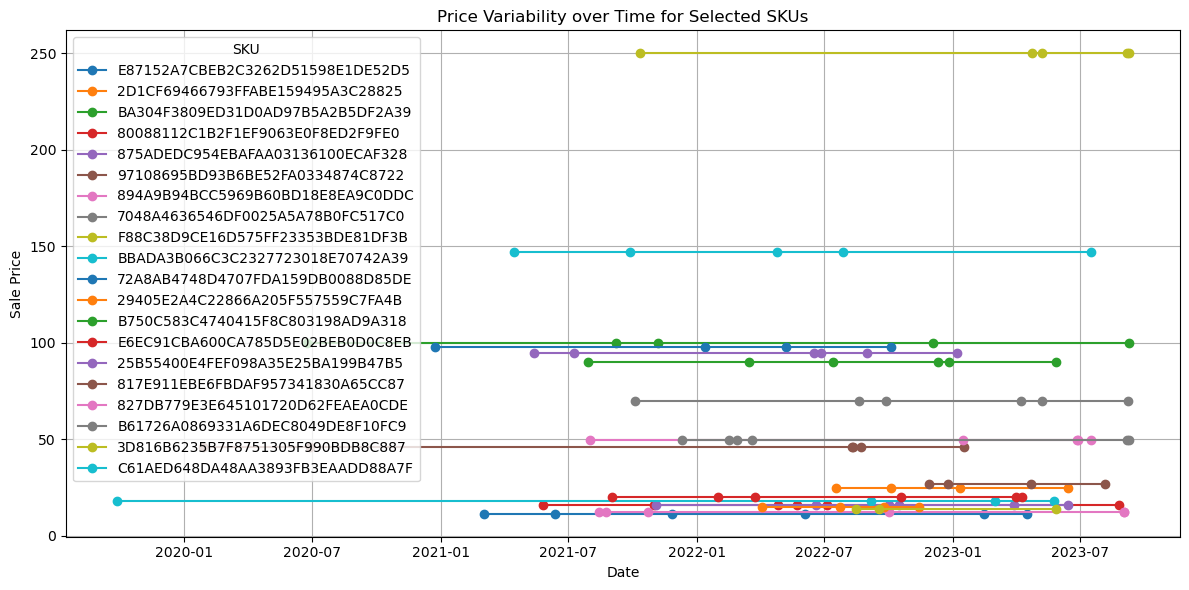

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Randomly select a few SKUs for visualization
num_skus = 20  # number of SKUs to visualize
selected_skus = df['sku'].sample(num_skus, random_state=42).tolist()

# Filter data for the selected SKUs
subset_data = df[df['sku'].isin(selected_skus)]

# Plotting
plt.figure(figsize=(12, 6))
for sku in selected_skus:
    sku_data = subset_data[subset_data['sku'] == sku]
    plt.plot(sku_data['date'], sku_data['sale_price'], label=sku, marker='o')

plt.title('Price Variability over Time for Selected SKUs')
plt.xlabel('Date')
plt.ylabel('Sale Price')
plt.legend(title='SKU')
plt.grid(True)
plt.tight_layout()
plt.show()
